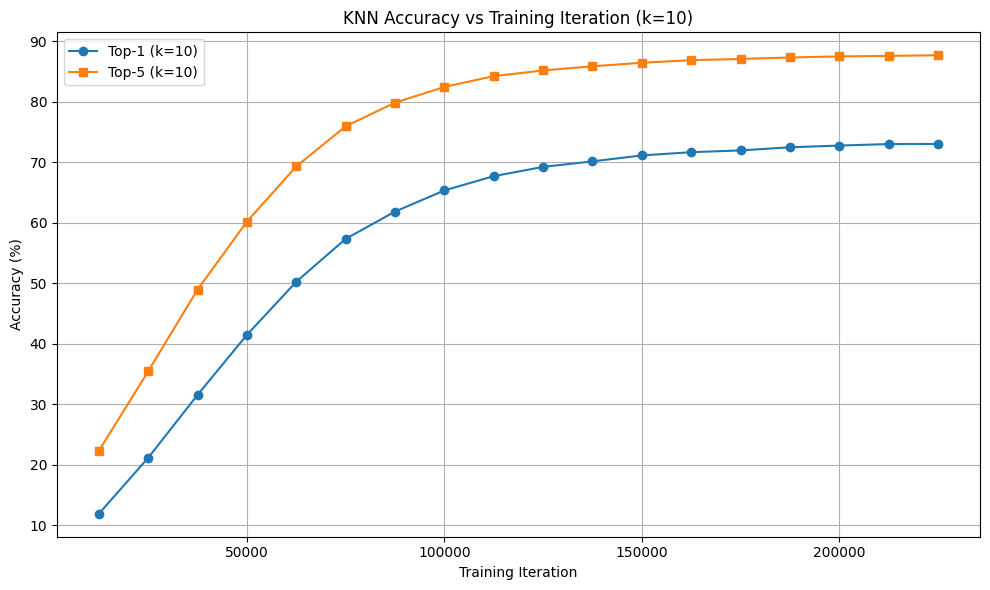

In [1]:
import os
import re
import matplotlib.pyplot as plt

# Base evaluation directory
eval_dir = "/work/dlclarge2/sunagadb-runs/dinov2/outputs_b14_long/eval"

# K value to track
target_k = 10

# Store results
iterations = []
top1_scores = []
top5_scores = []

# Iterate through training_<iter> directories
for entry in os.listdir(eval_dir):
    match = re.match(r'training_(\d+)', entry)
    if match:
        iteration = int(match.group(1))
        log_path = os.path.join(eval_dir, entry, "knn", "logs", "log.txt")

        if os.path.exists(log_path):
            with open(log_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    # Match line like: ('full', 20) classifier result: Top1: 73.16 Top5: 89.35
                    if f"({repr('full')}, {target_k}) classifier result" in line:
                        top1 = float(re.search(r'Top1: ([0-9.]+)', line).group(1))
                        top5 = float(re.search(r'Top5: ([0-9.]+)', line).group(1))
                        iterations.append(iteration)
                        top1_scores.append(top1)
                        top5_scores.append(top5)
                        break  # break after first match for this checkpoint

# Sort by iteration
sorted_data = sorted(zip(iterations, top1_scores, top5_scores))
iterations, top1_scores, top5_scores = zip(*sorted_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, top1_scores, marker='o', label=f'Top-1 (k={target_k})')
plt.plot(iterations, top5_scores, marker='s', label=f'Top-5 (k={target_k})')
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy (%)")
plt.title(f"KNN Accuracy vs Training Iteration (k={target_k})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


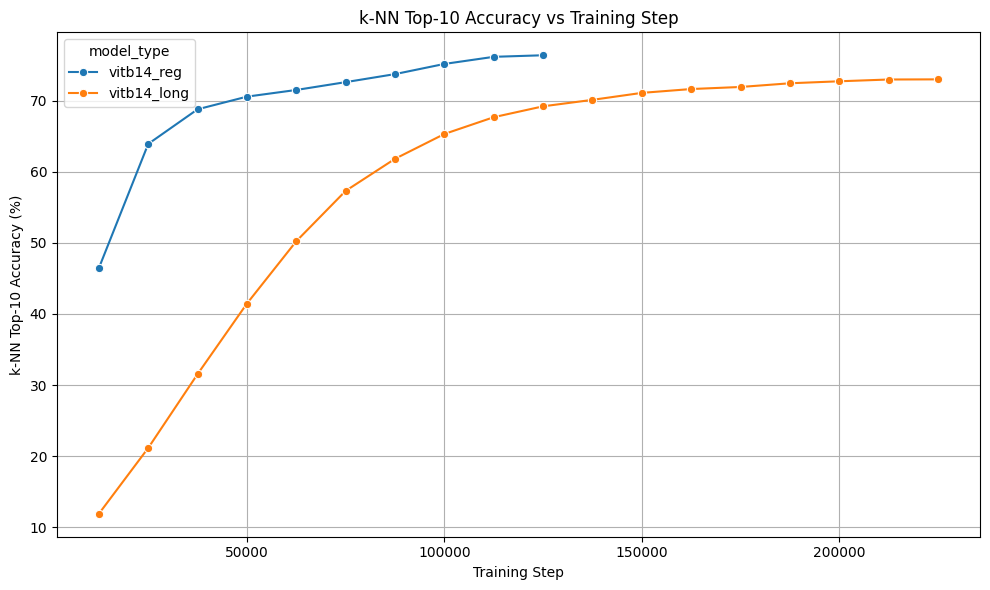

In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURATION ===
KNN_DIRS = {
    'vitb14_reg': "/work/dlclarge2/sunagadb-runs/dinov2/outputs_b14/eval",
    'vitb14_long': "/work/dlclarge2/sunagadb-runs/dinov2/outputs_b14_long/eval"
}
SPAIR_LOG_FILE = "spair_correspondence.log"
TARGET_K = 10  # for k-NN accuracy

# === STEP 1: Load KNN Accuracy from Logs ===
knn_records = []

for model_type, base_dir in KNN_DIRS.items():
    for entry in os.listdir(base_dir):
        match = re.match(r'training_(\d+)', entry)
        if match:
            iteration = int(match.group(1))
            log_path = os.path.join(base_dir, entry, "knn", "logs", "log.txt")

            if os.path.exists(log_path):
                with open(log_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if f"('full', {TARGET_K}) classifier result" in line:
                            top1 = float(re.search(r'Top1: ([0-9.]+)', line).group(1))
                            top5 = float(re.search(r'Top5: ([0-9.]+)', line).group(1))
                            knn_records.append({
                                'step': iteration,
                                'knn_top1': top1,
                                'knn_top5': top5,
                                'model_type': model_type
                            })
                            break
                        
# === STEP 2: Convert to DataFrame and Sort ===
df_knn = pd.DataFrame(knn_records)
df_knn = df_knn.sort_values(by='step')

# === STEP 3: Plot k-NN Top-1 Accuracy vs Training Step ===
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_knn, x='step', y='knn_top1', hue='model_type', marker='o')
plt.title(f'k-NN Top-{TARGET_K} Accuracy vs Training Step')
plt.xlabel('Training Step')
plt.ylabel(f'k-NN Top-{TARGET_K} Accuracy (%)')
plt.grid(True)
plt.tight_layout()
plt.show()
